In [3]:
import os

import pandas
import wfdb
from wfdb import processing
import numpy as np
from scipy import interpolate

In [123]:
class HeartbeatSlicer:
    def __init__(self, record_path, sampfrom, sampto, num_heartbeats=3):
        self.record = wfdb.rdrecord(record_name=record_path, sampfrom=sampfrom, sampto=sampto)
        self.annotations = wfdb.rdann(record_name=record_path, extension='atr', sampfrom=sampfrom, sampto=sampto, shift_samps=True)
        self.ann_symbols = self.annotations.symbol
        self.ecg_data = self.record.p_signal[:, 0]
        self.sampling_rate = self.record.fs
        self.peak_indices = self.detect_peaks()
        self.num_heartbeats = num_heartbeats


    def detect_peaks(self):
        """
        Detects peaks in the ECG data.

        Returns: numpy array with the indices of peaks.
        """

        # peak_indices = processing.gqrs_detect(sig=self.ecg_data, fs=self.sampling_rate)

        #Or use annoted peaks???
        peak_indices = self.annotations.sample


        return peak_indices


    def interpolate_sequence(self):
        x = np.linspace(0, len(self.peak_indices) - 1, len(self.peak_indices) - 1)
        f = interpolate.interp1d(np.arange(len(self.peak_indices)), self.peak_indices, kind='cubic')
        print(f(x))

        return f(x)

    def slice_heartbeats(self):
        """
        Slice the ECG data into sequences of a fixed number of consecutive heartbeats.

        num_heartbeats : The number of consecutive heartbeats to include in each sequence.

        Returns: 2D numpy array, each row is a sequence of heartbeats.
        """
        heartbeats = []

        # FIXME: check distance between peaks???
        for i in range(self.num_heartbeats, len(self.peak_indices)-self.num_heartbeats):
            start = self.peak_indices[i] - (self.peak_indices[i] - self.peak_indices[i-self.num_heartbeats])//2
            end = self.peak_indices[i] +  (self.peak_indices[i+self.num_heartbeats] - self.peak_indices[i])//2
            sequence = self.ecg_data[start:end]

            heartbeats.append(sequence)

        return heartbeats


    def annotate_heartbeats(self):
        heartbeats = self.slice_heartbeats()
        # FIXME: add more labels
        anns = list(map(lambda x: 0 if x in ['N', '~'] else 1, self.ann_symbols[self.num_heartbeats:-self.num_heartbeats]))

        return np.column_stack((heartbeats, anns))





In [124]:
record = wfdb.rdrecord(record_name='data_original/nsrdb/1.0.0/16265', sampfrom=2000, sampto=5000)
annotation = wfdb.rdann('data_original/nsrdb/1.0.0/16265', 'atr', sampfrom=2000, sampto=5000, shift_samps=True, summarize_labels=True)
sliced = HeartbeatSlicer(record_path='data_original/nsrdb/1.0.0/16265', sampfrom=2000, sampto=5000, num_heartbeats=3)

/home/pap1rana/.local/lib/python3.10/site-packages/wfdb/io/annotation.py:1355: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  contained_labels = label_map.loc[index_vals, :]


In [125]:
print(sliced.peak_indices)
# sliced.interpolate_sequence()

[  38  117  197  278  357  438  522  606  691  774  856  941 1029 1113
 1195 1277 1360 1441 1522 1601 1681 1761 1840 1920 2000 2079 2159 2240
 2323 2406 2487 2569 2651 2733 2813 2895 2978]


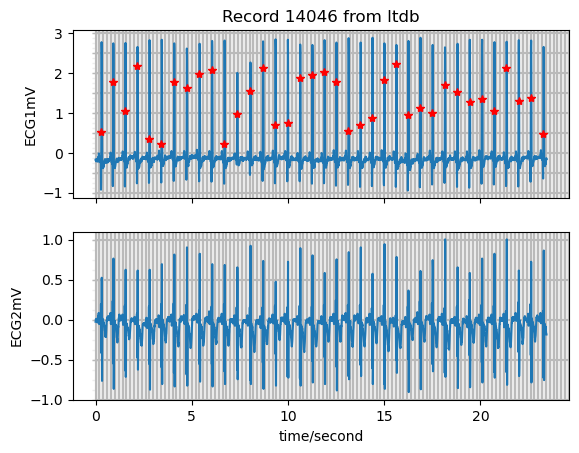

In [126]:
wfdb.plot_wfdb(record=record, annotation=annotation, title='Record 14046 from ltdb', ecg_grids='all')

In [127]:
heartbeats2 = sliced.slice_heartbeats()
print(len(heartbeats2))
print(len(sliced.peak_indices))

31
37


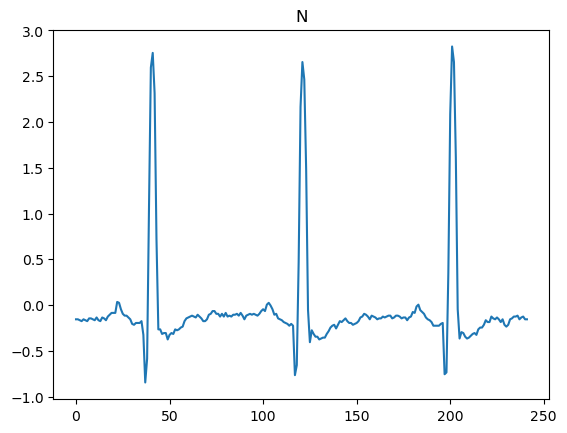

In [128]:
import matplotlib.pyplot as plt

plt.plot(heartbeats2[0])
plt.title(annotation.symbol[20])
plt.show()


In [129]:
print(annotation.sample)

[  38  117  197  278  357  438  522  606  691  774  856  941 1029 1113
 1195 1277 1360 1441 1522 1601 1681 1761 1840 1920 2000 2079 2159 2240
 2323 2406 2487 2569 2651 2733 2813 2895 2978]


In [130]:
print(sliced.peak_indices)

[  38  117  197  278  357  438  522  606  691  774  856  941 1029 1113
 1195 1277 1360 1441 1522 1601 1681 1761 1840 1920 2000 2079 2159 2240
 2323 2406 2487 2569 2651 2733 2813 2895 2978]


In [131]:
print(annotation.sample - sliced.peak_indices)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [132]:
print(annotation.symbol)

['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']


In [133]:
annotation.contained_labels

,label_store,symbol,description,n_occurrences
1,1,N,Normal beat,37


In [134]:
sliced.annotate_heartbeats()

/usr/lib/python3/dist-packages/numpy/lib/shape_base.py:652: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(v)


array([[array([-0.155, -0.155, -0.165, -0.175, -0.155, -0.165, -0.175, -0.145,
               -0.145, -0.155, -0.165, -0.135, -0.165, -0.175, -0.135, -0.145,
               -0.165, -0.125, -0.105, -0.085, -0.085, -0.085,  0.035,  0.025,
               -0.045, -0.095, -0.115, -0.115, -0.135, -0.155, -0.205, -0.215,
               -0.195, -0.195, -0.195, -0.175, -0.325, -0.845, -0.585,  1.055,
                2.595,  2.755,  2.315,  0.725, -0.265, -0.265, -0.315, -0.305,
               -0.305, -0.375, -0.325, -0.305, -0.315, -0.265, -0.275, -0.265,
               -0.245, -0.235, -0.175, -0.145, -0.135, -0.125, -0.115, -0.125,
               -0.135, -0.105, -0.125, -0.145, -0.175, -0.175, -0.155, -0.105,
               -0.095, -0.065, -0.065, -0.095, -0.095, -0.125, -0.095, -0.125,
               -0.085, -0.125, -0.115, -0.125, -0.105, -0.105, -0.095, -0.115,
               -0.085, -0.115, -0.155, -0.115, -0.105, -0.095, -0.105, -0.095,
               -0.105, -0.115, -0.095, -0.065, -0.04

In [135]:
import pandas
data = pandas.DataFrame(sliced.annotate_heartbeats())

/usr/lib/python3/dist-packages/numpy/lib/shape_base.py:652: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(v)


In [138]:
test = HeartbeatSlicer("data_original/mitdb/1.0.0/106", sampfrom=0, sampto=200000).annotate_heartbeats()


/usr/lib/python3/dist-packages/numpy/lib/shape_base.py:652: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(v)


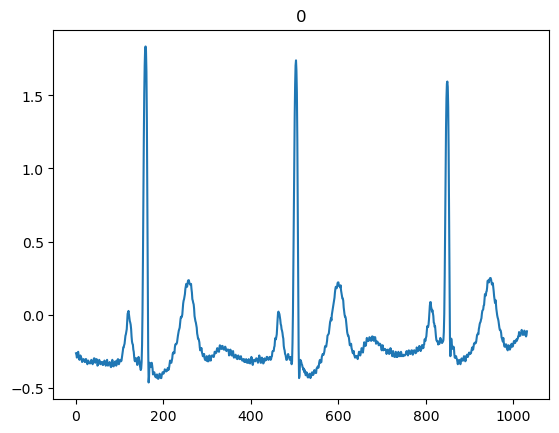

In [139]:
plt.plot(test[35][0])
plt.title(test[35][1])
plt.show()